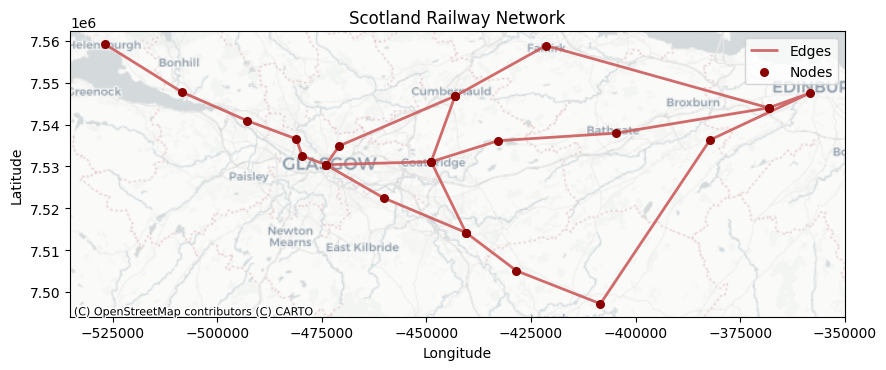

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import pandas as pd



# Define file paths
toy_node_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\QGISshp\Scotland_node_data.shp"
toy_edge_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\QGISshp\Scotland_edge_data.shp"

# Load the shapefiles
toy_node = gpd.read_file(toy_node_path)
toy_edge = gpd.read_file(toy_edge_path)

# Convert CRS to Web Mercator (EPSG:3857) for basemap compatibility
toy_edge = toy_edge.to_crs(epsg=3857)
toy_node = toy_node.to_crs(epsg=3857)

# Create a plot with network and basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges and nodes
toy_edge.plot(ax=ax, color="indianred", linewidth=2, alpha=0.9, label="Edges", zorder=1)
toy_node.plot(ax=ax, color="darkred", markersize=30, label="Nodes", zorder=2)

# Add a basemap from Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=0)

plt.legend()
plt.title("Scotland Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Nodes
n1: (-526743.9326977674, 7559191.047008602)
n2: (-508433.02285110863, 7547787.179290685)
n3: (-492770.94734187395, 7540915.577303931)
n4: (-481058.8356108721, 7536566.09327646)
n5: (-479690.78206530923, 7532536.382650457)
n6: (-474003.90093657264, 7530406.725499618)
n7: (-470848.7340172999, 7534904.792664699)
n8: (-460120.2099542361, 7522438.511371442)
n9: (-448851.26344105584, 7531134.767801062)
n10: (-443145.7676481675, 7546818.836540823)
n11: (-440545.8355925146, 7514209.841210318)
n12: (-432817.4774551757, 7536151.651174133)
n13: (-428455.99388436903, 7505072.666500858)
n14: (-421396.41021384794, 7558889.676746716)
n15: (-408396.38156367984, 7497188.819354335)
n16: (-404773.35276562383, 7537954.068966589)
n17: (-382215.06639498885, 7536339.935614771)
n18: (-368205.76442648796, 7544009.876788179)
n19: (-358352.66333297483, 7547526.255708998)

Edges (Properly Ordered & Bidirectional):
e1: n1 → n2
e2: n2 → n1
e3: n2 → n3
e4: n3 → n2
e5: n3 → n4
e6: n4 → n3
e7: n4 → n5
e8: n5 → n

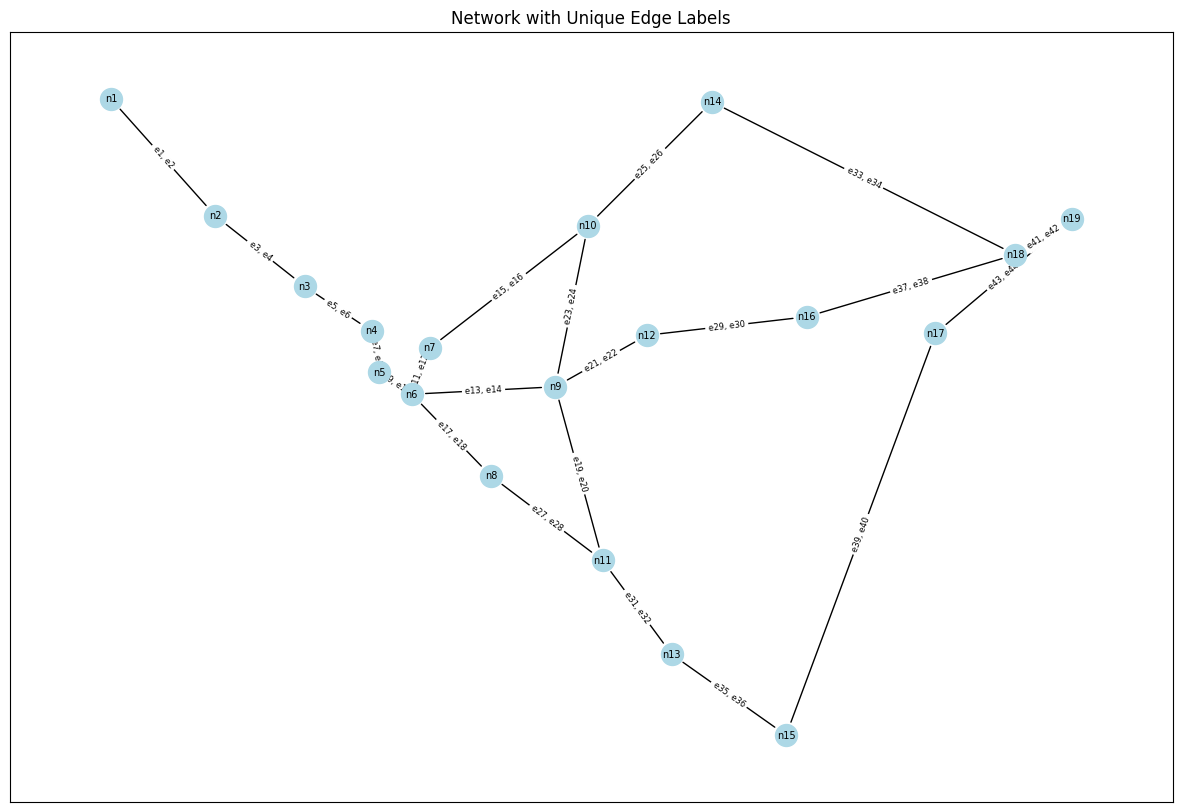

In [2]:
import networkx as nx



# 1. Node numbering (n1, n2, ...)
unique_coords = list(set((row.geometry.x, row.geometry.y) for row in toy_node.itertuples()))
sorted_coords = sorted(unique_coords, key=lambda coord: (coord[0], -coord[1]))

nodes = {f"n{i+1}": coord for i, coord in enumerate(sorted_coords)}

print("Nodes")
for node_name, coords in nodes.items():
    print(f"{node_name}: {coords}")



# 2. Edge numbering (e1, e2, ...)
unique_coords = list(set((row.geometry.x, row.geometry.y) for row in toy_node.itertuples())) # Extract unique coordinates (remove duplicates)
sorted_coords = sorted(unique_coords, key=lambda coord: (coord[1], -coord[0])) # Sort coordinates: First by Y (ascending), then by X (descending)

coord_to_node = {coord: node for node, coord in nodes.items()}

# Collect edges into a list (before sorting)
edge_list = []

for _, row in toy_edge.iterrows():
    line: LineString = row.geometry  
    coords = list(line.coords)  # Extract coordinates from LINESTRING

    for i in range(len(coords) - 1):
        start_coord = coords[i]
        end_coord = coords[i + 1]

        # Match coordinates with nodes
        start_node = coord_to_node.get(start_coord)
        end_node = coord_to_node.get(end_coord)

        if start_node and end_node:
            edge_list.append((start_node, end_node))

edge_list = sorted(edge_list, key=lambda edge: (int(edge[0][1:]), int(edge[1][1:]))) # Sort edges by smallest starting node number

# Create bidirectional edges with correct numbering
edges = {}
arc_id = 1  

for start_node, end_node in edge_list:
    edges[f"e{arc_id}"] = (start_node, end_node)   # Forward edge
    edges[f"e{arc_id+1}"] = (end_node, start_node) # Reverse edge
    arc_id += 2  # Increment by 2 (to maintain odd-even numbering)

print("\nEdges (Properly Ordered & Bidirectional):")
for edge_name, (start_node, end_node) in edges.items():
    print(f"{edge_name}: {start_node} → {end_node}")



# 3. Convert edges to arc format
arcs = [(u, v) for _, (u, v) in edges.items()]



# 4. Compute Euclidean distances
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}

print("Arc Distances:", arc_distance)



# 5. Create a network graph
# Create the graph using extracted data
G = nx.DiGraph()

# Add nodes and edges
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items(): 
    G.add_edge(u, v, weight=arc_distance[edge_name])

# Remove duplicate edges
unique_edges = set()
edge_name_map = {}

for edge_name, (u, v) in edges.items():
    if (v, u) not in unique_edges:  
        unique_edges.add((u, v))
        reverse_edge_name = [k for k, (a, b) in edges.items() if (a, b) == (v, u)]  
        if reverse_edge_name:
            edge_label = f"{edge_name}, {reverse_edge_name[0]}"  
        else:
            edge_label = edge_name  
        
        edge_name_map[(u, v)] = edge_label  

# Plot the network topology
plt.figure(figsize=(15, 10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(unique_edges),  
    arrowstyle='-',
    min_target_margin=10,
    min_source_margin=10
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_name_map, font_size=6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Network with Unique Edge Labels")
plt.show()

In [3]:
import sys
import os
sys.path.append(r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\BNS-JT-python")

import re 
import json
import gc  
import copy

import numpy as np
from gurobipy import Model, GRB, quicksum
from scipy.stats import beta

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

import BNS_JT.brc as brc
import BNS_JT.cpm as cpm
import BNS_JT.variable as variable
import BNS_JT.operation as operation
import BNS_JT.branch as branch
import batch

gc.collect()  # memory clean-up
%matplotlib inline

In [6]:
nodes = nodes  
edges = edges  
arcs = arcs
arc_distance = arc_distance 



# 1. Generate arc failure probabilities based on arc distances (longer distance -> higher failure probability)
# Get the minimum and maximum arc distances
min_dist = min(arc_distance.values())
max_dist = max(arc_distance.values())

# Failure probability range (0.01 ~ 0.1)
min_prob = 0.01
max_prob = 0.1

def compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob):
    normalized_dist = (distance - min_dist) / (max_dist - min_dist)  # Normalize to [0,1]
    return round(min_prob + normalized_dist * (max_prob - min_prob), 4)

# Generate failure probability for each edge
probs_dynamic = {
    edge: {
        0: compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 
        1: round(1 - compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 4)
    }
    for edge, dist in arc_distance.items()
}

# Sort edges by numeric order
def numeric_sort(edge):
    return int(edge[1:])  # Extract numeric part from "eX"

probs_sorted = {k: probs_dynamic[k] for k in sorted(probs_dynamic, key=numeric_sort)}

# Print formatted probabilities
print(json.dumps(probs_sorted, indent=4, separators=(",", ": ")))
probs = probs_sorted
probs_cpm = copy.deepcopy(probs)
print(probs_cpm)



# 2. Assign capacities to each arcs
# Initial intact capacity (Unchanged from original)
reduced_capacity_edges = {"e10", "e12", "e20", "e21",
                          "e25", "e26", "e42", "e43"}

intact_capacity = {edge: 35 if edge in reduced_capacity_edges else 40 for edge in edges}

# Function to generate random component states (0 or 1) based on failure probabilities
def generate_comps_st(probs):
    comps_st = {}

    for edge, prob in probs.items():
        if isinstance(prob, dict) and 0 in prob and 1 in prob:  # Ensure correct structure
            comps_st[edge] = np.random.choice([0, 1], p=[prob[0], prob[1]])
        else:
            print(f"Warning: Invalid probability format for edge {edge}: {prob}")  # Debugging message

    return comps_st

# Compute arc capacities
comps_st = generate_comps_st(probs_sorted)  # Use directly without JSON conversion
arc_capacity = {edge: int(intact_capacity[edge] * comps_st[edge]) for edge in intact_capacity}

print(json.dumps(arc_capacity, indent=4, separators=(",", ": ")))



# 3. Compute maximum allowable distance
# Demand data
demand = {
    "k1": {"origin": "n10", "destination": "n13", "amount": 32},
    "k2": {"origin": "n2", "destination": "n12", "amount": 34},
    "k3": {"origin": "n10", "destination": "n8", "amount": 15},
    "k4": {"origin": "n7", "destination": "n18", "amount": 35},
    "k5": {"origin": "n17", "destination": "n12", "amount": 40},
    "k6": {"origin": "n18", "destination": "n12", "amount": 49},
    "k7": {"origin": "n19", "destination": "n15", "amount": 42},
    "k8": {"origin": "n10", "destination": "n4", "amount": 49},
    "k9": {"origin": "n16", "destination": "n12", "amount": 43},
    "k10": {"origin": "n10", "destination": "n1", "amount": 17},
    "k11": {"origin": "n3", "destination": "n1", "amount": 30},
    "k12": {"origin": "n4", "destination": "n15", "amount": 38}
}

# Compute max allowable distance
avg_velo = 149  # Speed in km/h
max_distance = {}

for commodity, info in demand.items():
    shortest_distance = nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight')
    max_allowable_time = (shortest_distance * 60) / avg_velo + 4500  # 9000 minutes extra
    max_distance[commodity] = max_allowable_time * avg_velo / 60  # Store per commodity

    print(f"\nCommodity: {commodity}")
    print(f"  Shortest distance: {shortest_distance} km")
    print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
    print(f"  Maximum allowable distance: {max_distance[commodity]:.2f} km")


from collections import defaultdict

# 기존 정의된 변수들 활용
# nodes, edges, arcs, arc_distance, demand 등 이미 존재한다고 가정함.

# 열차 평균 속력 (단위: km/h)
avg_velo = 149  

# 시간 변환 factor (거리가 km 단위라고 가정하면, 분 단위로 변환)
def compute_travel_time(distance, speed_kmh=avg_velo):
    return max(1, int(round((distance / speed_km_min))))  # 최소 1분

speed_km_min = avg_velo / 60  # km/min

# 모든 열차에 대해 가능한 모든 경로를 찾고 시간 배정
allocation = defaultdict(list)

for k, info in demand.items():
    origin = info["origin"]
    destination = info["destination"]

    # 가능한 경로 최대 3개 (너무 많으면 계산 복잡, 제한할 수 있음)
    paths = list(nx.shortest_simple_paths(G, origin, destination, weight='weight'))[:3]

    path_id = 1
    for path in paths:
        blocks = []
        current_time = 0  # 모든 열차 출발 시각 0으로 가정 (임의로 조정 가능)

        for i in range(len(path)-1):
            u, v = path[i], path[i+1]

            # arc 이름 얻기
            edge_name = next((name for name, nodes_pair in edges.items() if nodes_pair == (u, v)), None)
            if edge_name is None:
                continue  # 잘못된 edge 무시

            distance = arc_distance[edge_name]
            travel_time = compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob)
            travel_time = max(1, int(round(distance / speed_km_min)))  # 최소 1분 보장

            block = {
                "arc": (u, v),
                "start": current_time,
                "end": current_time + travel_time
            }

            blocks.append(block)
            current_time += travel_time

        allocation[k].append({
            "path_id": path_id,
            "blocks": blocks
        })
        path_id += 1

# allocation schema 구성 (자원 별로)
allocation_schema = defaultdict(list)

for k, paths in allocation.items():
    for path in paths:
        for blk in path["blocks"]:
            arc = blk["arc"]
            allocation_schema[arc].append({
                "train": k,
                "start": blk["start"],
                "end": blk["end"]
            })

# allocation schema 출력 예시
for arc, intervals in allocation_schema.items():
    print(f"\nArc {arc} allocation intervals:")
    for interval in intervals:
        print(f"  Train {interval['train']}: {interval['start']} - {interval['end']} min")


{
    "e1": {
        "0": 0.0406,
        "1": 0.9594
    },
    "e2": {
        "0": 0.0406,
        "1": 0.9594
    },
    "e3": {
        "0": 0.0327,
        "1": 0.9673
    },
    "e4": {
        "0": 0.0327,
        "1": 0.9673
    },
    "e5": {
        "0": 0.0245,
        "1": 0.9755
    },
    "e6": {
        "0": 0.0245,
        "1": 0.9755
    },
    "e7": {
        "0": 0.01,
        "1": 0.99
    },
    "e8": {
        "0": 0.01,
        "1": 0.99
    },
    "e9": {
        "0": 0.0132,
        "1": 0.9868
    },
    "e10": {
        "0": 0.0132,
        "1": 0.9868
    },
    "e11": {
        "0": 0.0122,
        "1": 0.9878
    },
    "e12": {
        "0": 0.0122,
        "1": 0.9878
    },
    "e13": {
        "0": 0.0469,
        "1": 0.9531
    },
    "e14": {
        "0": 0.0469,
        "1": 0.9531
    },
    "e15": {
        "0": 0.0557,
        "1": 0.9443
    },
    "e16": {
        "0": 0.0557,
        "1": 0.9443
    },
    "e17": {
        "0": 0.0307,
     